## Analyzing Employee Attrition: A Deep Dive
### Introduction

#### Employee attrition, or turnover, is a significant challenge faced by organizations worldwide. Understanding the factors that contribute to attrition is crucial for retaining top talent and maintaining a healthy work environment. In this analysis, we will explore various aspects of employee attrition using a fictional dataset provided by IBM data scientists.

## Importing Libraries 
## [Note :  Install necessary libraries (if needed)]

In [2]:
# Importing essential libraries for data analysis and machine learning
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve, classification_report, average_precision_score)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppressing warnings for a cleaner output
warnings.filterwarnings('ignore')

In [3]:
# Loading the employee attrition dataset
df = pd.read_csv('HRdata.csv')

# Displaying the first few rows of the dataset
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Checking unique values in categorical columns for initial insights
print(df.Department.unique())
print(df.BusinessTravel.unique())
print(df.EducationField.unique())
print(df.Gender.unique())
print(df.JobRole.unique())
print(df.MaritalStatus.unique())
print(df.Attrition.unique())

['Sales' 'Research & Development' 'Human Resources']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
['Female' 'Male']
['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
['Single' 'Married' 'Divorced']
['Yes' 'No']


In [5]:
# Checking data types of all columns
print(df.dtypes)

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [6]:
# Create a mapping for categorical columns
categorical_mappings = {
    'BusinessTravel': {'Travel_Rarely': 1, 'Travel_Frequently': 2, 'Non-Travel': 3},
    'Department': {'Sales': 1, 'Research & Development': 2, 'Human Resources': 3},
    'EducationField': {'Life Sciences': 1, 'Other': 2, 'Medical': 3, 'Marketing': 4, 'Technical Degree': 5, 'Human Resources': 6},
    'Gender': {'Male': 1, 'Female': 0},
    'JobRole': {
        'Sales Executive': 1, 'Research Scientist': 2, 'Laboratory Technician': 3,
        'Manufacturing Director': 4, 'Healthcare Representative': 5,
        'Manager': 6, 'Sales Representative': 7, 'Research Director': 8, 'Human Resources': 9
    },
    'MaritalStatus': {'Single': 1, 'Married': 2, 'Divorced': 3},
    'Over18': {'Y': 1},  # Over18 is binary so we can map 'Y' to 1
    'OverTime': {'Yes': 1, 'No': 0}  # Binary column, Yes/No
}

# Apply the mappings to convert categorical columns to integers
df.replace(categorical_mappings, inplace=True)

# If there are any NaNs created during the replacement, handle them by filling with a default value, such as -1 or 0
df.fillna(-1, inplace=True)

In [7]:
# Check if 'Yes' is still present in the OverTime column
print(df['OverTime'].unique())

# If 'Yes' or 'No' still appears, force the replacement again
df['OverTime'].replace({'Yes': 1, 'No': 0}, inplace=True)

# Now, convert all columns to int64 again
try:
    df = df.astype('int64')
except ValueError as e:
    print(f"Error occurred: {e}")

# Check the data types after conversion
print(df.dtypes)

[1 0]
Error occurred: invalid literal for int() with base 10: 'Yes'
Age                          int64
Attrition                   object
BusinessTravel               int64
DailyRate                    int64
Department                   int64
DistanceFromHome             int64
Education                    int64
EducationField               int64
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                       int64
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                      int64
JobSatisfaction              int64
MaritalStatus                int64
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                       int64
OverTime                     int64
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours         

In [8]:
print(df.isna().sum())

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [9]:
# Creating new features to enhance model predictive power
df['TotalExperience'] = df['YearsInCurrentRole'] + df['YearsWithCurrManager']
df['PromotionFrequency'] = df['YearsSinceLastPromotion'] / (df['YearsAtCompany'] + 0.001)

# Interaction features
df['JobLevel_YearsInRole'] = df['JobLevel'] * df['YearsInCurrentRole']
df['IncomePerJobLevel'] = df['MonthlyIncome'] / (df['JobLevel'] + 0.001)
df['YearsAtCompanyVsTotalYears'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 0.001)

# Additional features
df['EmployeeTenure'] = df['YearsAtCompany'] / (df['TotalWorkingYears'] + 0.001)
df['RelativeSalary'] = df['MonthlyIncome'] / df.groupby('Department')['MonthlyIncome'].transform('median')
df['AvgSatisfaction'] = (df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction']) / 3

# Creating a binary indicator for overtime
df['OvertimeIndicator'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)

In [10]:
# Checking for missing values
missing_values = df.isna().sum()
print(missing_values)

# Identifying outliers using IQR method
def find_outliers(col):
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(col):
        q1, q3 = col.quantile(0.25), col.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return [x for x in col if x < lower or x > upper]
    else:
        # Return an empty list if the column is not numeric
        return []

# Collecting columns that have outliers
outliers_columns = [col for col in df.columns if len(find_outliers(df[col])) > 0]
print(outliers_columns)

Age                           0
Attrition                     0
BusinessTravel                0
DailyRate                     0
Department                    0
DistanceFromHome              0
Education                     0
EducationField                0
EmployeeCount                 0
EmployeeNumber                0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 0
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtC

In [11]:
# Encoding categorical columns using LabelEncoder for model compatibility
labelenc = LabelEncoder()
categorical_columns = ['Attrition', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'BusinessTravel', 'OverTime']
for col in categorical_columns:
    df[col] = labelenc.fit_transform(df[col])

# Displaying dataset information after encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         1470 non-null   int64  
 1   Attrition                   1470 non-null   int32  
 2   BusinessTravel              1470 non-null   int64  
 3   DailyRate                   1470 non-null   int64  
 4   Department                  1470 non-null   int64  
 5   DistanceFromHome            1470 non-null   int64  
 6   Education                   1470 non-null   int64  
 7   EducationField              1470 non-null   int64  
 8   EmployeeCount               1470 non-null   int64  
 9   EmployeeNumber              1470 non-null   int64  
 10  EnvironmentSatisfaction     1470 non-null   int64  
 11  Gender                      1470 non-null   int64  
 12  HourlyRate                  1470 non-null   int64  
 13  JobInvolvement              1470 

In [12]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [13]:
# Split features and target
X = df.drop('Attrition', axis=1)  # Replace 'target_column' with the actual target column name
y = df['Attrition']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Identify object columns that need to be converted to numeric
object_cols = X.select_dtypes(include=['object']).columns.tolist()

# Display the object columns
print("Object columns:", object_cols)


Object columns: []


In [14]:
print(df.dtypes)

Age                             int64
Attrition                       int32
BusinessTravel                  int64
DailyRate                       int64
Department                      int64
DistanceFromHome                int64
Education                       int64
EducationField                  int64
EmployeeCount                   int64
EmployeeNumber                  int64
EnvironmentSatisfaction         int64
Gender                          int64
HourlyRate                      int64
JobInvolvement                  int64
JobLevel                        int64
JobRole                         int64
JobSatisfaction                 int64
MaritalStatus                   int64
MonthlyIncome                   int64
MonthlyRate                     int64
NumCompaniesWorked              int64
Over18                          int64
OverTime                        int64
PercentSalaryHike               int64
PerformanceRating               int64
RelationshipSatisfaction        int64
StandardHour

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling to features

# Assign X_final to be the scaled (or preprocessed) version of your feature matrix
X_final = X_scaled

# Now you can apply SMOTE on the transformed features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final, y)

print("Resampled feature shape:", X_resampled.shape)
print("Resampled target shape:", y_resampled.shape)

Resampled feature shape: (2466, 43)
Resampled target shape: (2466,)


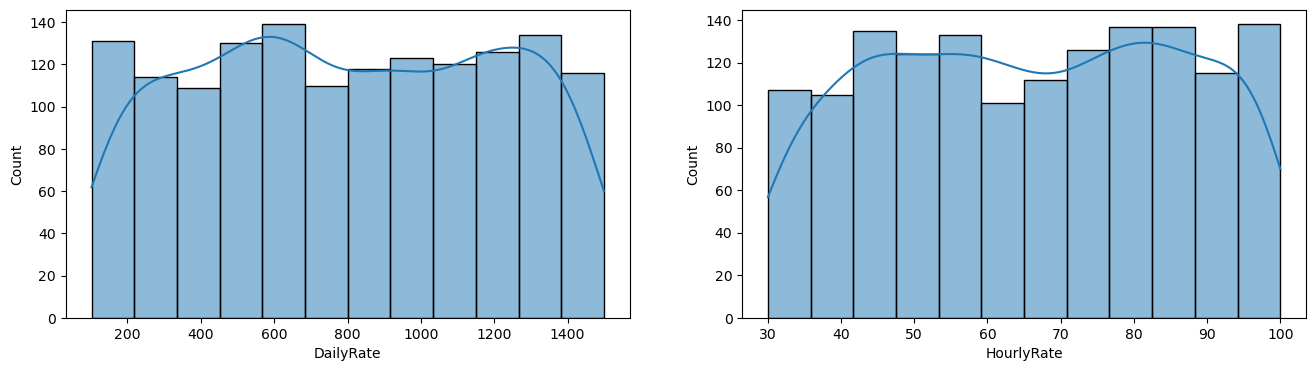

In [16]:
# Plotting histograms for numerical columns
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(df['DailyRate'], ax=ax[0], kde=True)
sns.histplot(df['HourlyRate'], ax=ax[1], kde=True)
plt.show()

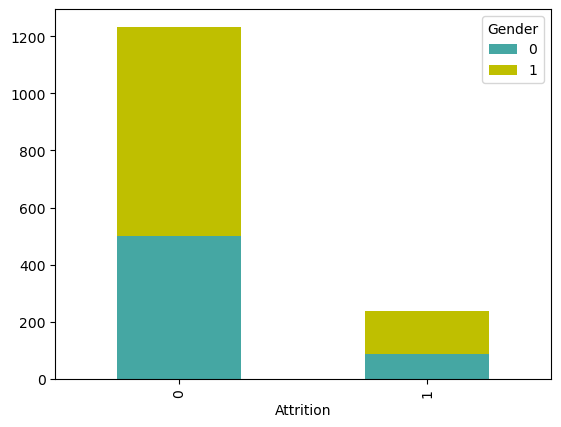

In [17]:
# Visualizing attrition by gender
df_plot_Gen = df.groupby(['Attrition', 'Gender']).size().unstack()
df_plot_Gen.plot(kind='bar', stacked=True, color=['#45A7A3', 'y'])
plt.show()

In [18]:
# Splitting the dataset into training and testing sets for model evaluation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [19]:
# Defining a function to evaluate various models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Collecting evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, 'predict_proba') else None
    report = classification_report(y_test, y_pred)

    print(f'Model: {model.__class__.__name__}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}' if roc_auc else 'ROC AUC Score: Not available for this model')
    print('Classification Report:\n', report)
    print('-' * 50)

# Evaluating multiple models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True)  # probability=True to calculate ROC AUC
]

for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

Model: LogisticRegression
Accuracy: 0.7635
Precision: 0.7552
Recall: 0.7817
ROC AUC Score: 0.8512
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76       369
           1       0.76      0.78      0.77       371

    accuracy                           0.76       740
   macro avg       0.76      0.76      0.76       740
weighted avg       0.76      0.76      0.76       740

--------------------------------------------------
Model: DecisionTreeClassifier
Accuracy: 0.8257
Precision: 0.8056
Recall: 0.8598
ROC AUC Score: 0.8256
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       369
           1       0.81      0.86      0.83       371

    accuracy                           0.83       740
   macro avg       0.83      0.83      0.83       740
weighted avg       0.83      0.83      0.83       740

-----------------------------------------------

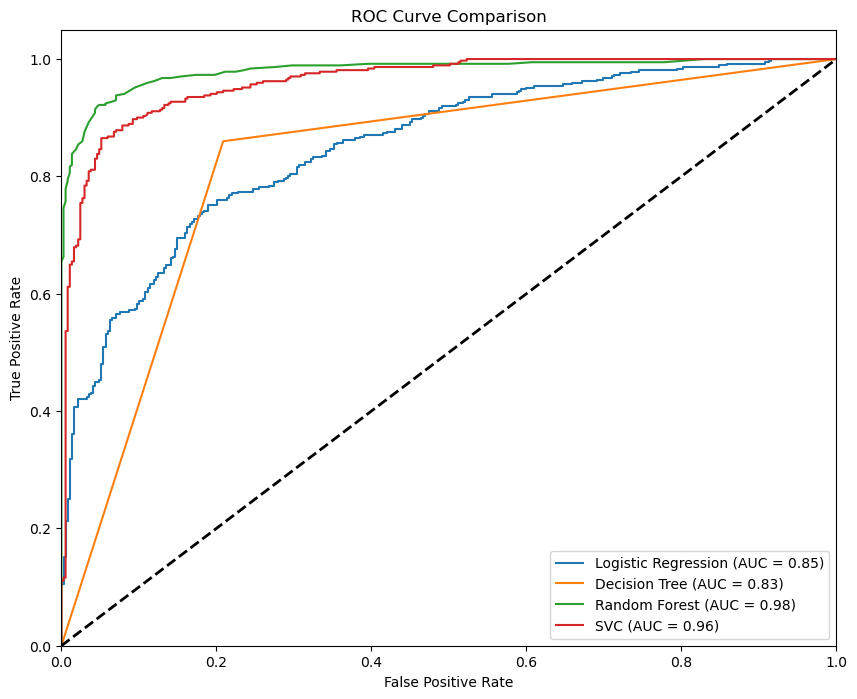

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = [LogisticRegression(random_state=42), DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42), SVC(random_state=42, probability=True)]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC']

plt.figure(figsize=(10, 8))

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

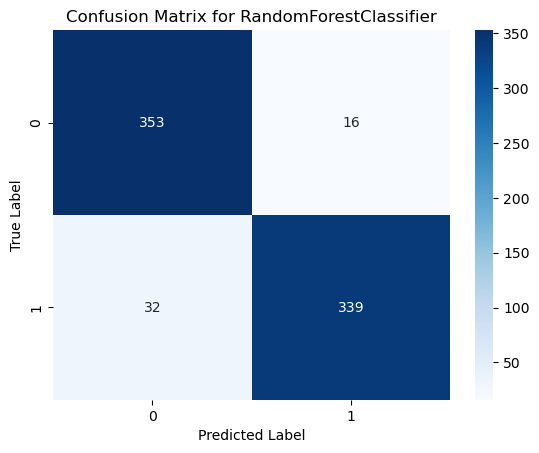

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot for RandomForestClassifier as an example
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix for RandomForestClassifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()